In [1]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.spatial import Delaunay


from igraph import *
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import random

In [2]:
# Read graph data into dataframe, remove unnecessary columns, only keep december months
directory = os.path.abspath("uber_data/")

graph_data = pd.read_csv(directory + '/san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv')
graph_data = graph_data.drop(['standard_deviation_travel_time', 'geometric_mean_travel_time', 'geometric_standard_deviation_travel_time'], axis=1)
graph_data = graph_data.drop(graph_data[graph_data.month != 12].index)
dec_data = graph_data.drop(['month'], axis=1)




In [3]:
# Remove duplicates and keep the mean of duplicate travel times# Remove  
dec_array = np.asarray(dec_data) # idk numpy seems easier to work with
existing_paths = {}
existing_locations = np.unique(np.concatenate([dec_array[:,0],dec_array[:,1]]))
counter = 0
for row in dec_array:
    locations = tuple(np.sort(row[0:2]))
    if locations in existing_paths:
        existing_paths[locations].append(row[2])
        counter += 1
    else:
        existing_paths[locations] = [row[2]]

In [4]:
# Write out a csv file with december data, where duplicates are averaged
# This will be used in R's igraph library to do graph analysis
with open(directory + '/december_data.txt','w') as f:
    for locations in existing_paths:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),np.mean(existing_paths[locations]))
        f.write(string)

In [5]:
# Load in the location data
with open(directory + '/san_francisco_censustracts.json') as json_data:
    geo_data = json.load(json_data)
geo_data = geo_data['features']

In [6]:
# Process the raw data into a dictionary where key is location ID, value is display name and coordinate list
location_dictionary = {}

for entry in geo_data:
    data = {}
    # Retrieve coordinate list and compute mean coordinates
    coord_list = entry['geometry']['coordinates'][0][0]
    mean_coord = np.mean(np.asarray(coord_list),axis=0)
    movement_id = entry['properties']['MOVEMENT_ID']

    data['coord_list'] = coord_list
    data['mean_coord'] = mean_coord
    data['display_name'] = entry['properties']['DISPLAY_NAME']
    location_dictionary[movement_id] = data
    
    
    

In [7]:
# QUESTION 6: Report the number of nodes and edges in G.

uber_graph = Graph.Read(directory + '/december_data.txt', format='ncol', directed=False)

gcc = uber_graph.components().giant()
summary(gcc)
summary(uber_graph)

print("We can see 7 nodes were removed")


# write graph to file
Graph.write_ncol(gcc, directory + '/uber_gcc.txt')

IGRAPH UNW- 1898 321703 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 1905 321713 -- 
+ attr: name (v), weight (e)
We can see 7 nodes were removed


In [8]:
# QUESTION 7: Build a minimum spanning tree (MST) of graph G. Report the street addresses
# of the two endpoints of a few edges. Are the results intuitive?

# edges in mst should be relatively shorter.

mst = gcc.spanning_tree(weights = gcc.es["weight"])
vertices = mst.vs()
summary(mst)

print('-'*50)

rand_n = []
for x in range(3):
    rand_n.append(random.randint(0,len(mst.es())-1))

count = 0
rand_e = []
for e in mst.es():
    st = e.tuple
    if count < 10:
        print(location_dictionary[vertices[st[0]]['name']]['display_name'],'---',location_dictionary[vertices[st[1]]['name']]['display_name'])
    
    if count in rand_n:
        rand_e.append(location_dictionary[vertices[st[0]]['name']]['display_name'])
        rand_e.append(location_dictionary[vertices[st[1]]['name']]['display_name'])
    count += 1
#     print(location_dictionary[str(st[0])]['display_name'], '---', location_dictionary[str(st[1])]['display_name'])

IGRAPH UNW- 1898 1897 -- 
+ attr: name (v), weight (e)
--------------------------------------------------
700 Lakeville Circle, Petaluma --- 7700 Lakeville Highway, Petaluma
200 Ely Road North, Petaluma --- 2600 Goodwin Avenue, Penngrove
Interstate 505, Vacaville --- Sikes Road, Dixon
3800 Mission Drive, Santa Cruz --- 1200 Rodriguez Street, Santa Cruz
19200 San Ramon Valley Boulevard, San Ramon --- 0 Mesa Vista Court, San Ramon
11600 Bruceville Road, Elk Grove --- 600 Vorden Road, Walnut Grove
2100 Canoas Garden Avenue, South San Jose, San Jose --- 2000 Little Orchard Street, South San Jose, San Jose
3500 Hicks Valley Road, Novato --- 0 Black Oak Lane, Novato
13700 Westboro Drive, Alum Rock, San Jose --- 500 Massar Avenue, East San Jose, San Jose
1000 Sterling Avenue, Berkeley Hills, Berkeley --- 1400 Queens Road, Berkeley Hills, Berkeley


In [9]:
# QUESTION 8: Determine what percentage of triangles in the graph (sets of 3 points on the
# map) satisfy the triangle inequality. You do not need to inspect all triangles, you can just estimate
# by random sampling of 1000 triangles.

def check_if_satisfy():
    current_set = ()
    indices = []
    weights = []
    
    for index in range(0,3): #generate 3 indices
        indices.append(random.randint(0,max_index))        
    current_set = tuple(sorted(indices))
    
    while(current_set in combined_set):
        for index in range(0,3): #generate 3 indices
            indices.append(random.randint(0,max_index))        
        current_set = tuple(sorted(indices))
        
    for e in current_set:
        weights.append(gcc_es[e]["weight"])
    
    if weights[0] < weights[1] + weights[2] and weights[1] < weights[0] + weights[2] and weights[2] < weights[0] + weights[1]:
        return True, weights, current_set
    else:
        return False, weights, current_set

#asked to test whether triangle inequality stands for all triangle
# find to sample triangle not gauranteed uniform distribution

sample_triangles = 1000
max_index = len(gcc.vs()) - 1  # used for generating index
gcc_vertices = gcc.vs()
gcc_es = EdgeSeq(gcc)

combined_set = set()
satisfied = 0

count = 0
while count < sample_triangles:
    #randomly generated 1000 triangles
                       
    for i in range(0,3):
        satisfy, weights, current_set = check_if_satisfy()
        if satisfy:
            break
                       
    combined_set.add(current_set)
    
    print('='*50,'triangle',count+1)
   
    edges = []
    start_nodes = []
    end_nodes = []
    for e in current_set:
        edges.append(gcc_es[e])
        
        source_vertex = gcc.vs[gcc_es[e].source]
        target_vertex = gcc.vs[gcc_es[e].target]
        
        start_nodes.append(location_dictionary[source_vertex['name']]['display_name'])
        end_nodes.append(location_dictionary[target_vertex['name']]['display_name'])
    
    for i in range(0, 3):
        print('weight:', weights[i],'edge ' + str(i+1) + ':', start_nodes[i], '---', end_nodes[i])
    
    if satisfy:
        satisfied += 1
        print('traingle satisfied')
    else:
        print('triangle not satisfied')
        
    count += 1  
    
print('percent:', str(satisfied / sample_triangles))

================================================== triangle 1
weight: 1132.34 edge 1: 800 Jury Court, North San Jose, San Jose --- 4400 Bella Madeira Lane, Alum Rock, San Jose
weight: 1320.79 edge 2: 500 John Muir Drive, Lakeshore, San Francisco --- 0 Rossi Avenue, Richmond District, San Francisco
weight: 1496.01 edge 3: 300 East 9th Street, Gilroy --- 5300 Canyon Hills Lane, East San Jose, San Jose
traingle satisfied
================================================== triangle 2
weight: 936.25 edge 1: 200 Silverlake Drive, Lakewood, Sunnyvale --- 3000 Waverley Street, Midtown, Palo Alto
weight: 1695.28 edge 2: 200 North 5th Street, Central San Jose, San Jose --- 4500 De Silva Street, South Sundale, Fremont
weight: 2065.26 edge 3: 1100 Taylor Street, Nob Hill, San Francisco --- 0 Upper Ames Avenue, Ross
traingle satisfied
================================================== triangle 3
weight: 1151.77 edge 1: 2200 California Street, Mountain View --- 800 Live Oak Avenue, Downtown Menlo Par

weight: 2581.09 edge 2: Entrada, Santa Rosa --- 2900 Kerner Boulevard, San Rafael
weight: 1961.25 edge 3: 4700 18th Street, Eureka Valley, San Francisco --- Frenchmans Creek Road, Half Moon Bay
traingle satisfied
================================================== triangle 88
weight: 1641.99 edge 1: 24500 Surrey Way, Santa Clara, Hayward --- Bollinger Estates Court, San Ramon
weight: 1491.75 edge 2: 300 East 9th Street, Gilroy --- 400 Calero Avenue, South San Jose, San Jose
weight: 2617.51 edge 3: 200 Union Avenue, Campbell --- 1200 Helen Drive, Millbrae
traingle satisfied
================================================== triangle 89
weight: 3145.09 edge 1: 400 Jane Drive, Windsor --- 0 Hamilton Drive, Mill Valley
weight: 1377.35 edge 2: 100 Monte Verde Drive, Vacaville --- Unnamed Road, Benicia
weight: 711.32 edge 3: 8000 A Street, Windsor --- 900 Powell Avenue, Healdsburg
triangle not satisfied
================================================== triangle 90
weight: 1549.96 edge 1: 250

weight: 1746.78 edge 2: 100 Rutledge Street, Bernal Heights, San Francisco --- 1300 Holly Street, San Carlos
weight: 728.2 edge 3: 1000 Queen Anne Drive, West San Jose, San Jose --- 900 Pepper Tree Lane, Santa Clara
traingle satisfied
================================================== triangle 179
weight: 1063.04 edge 1: 7000 Auto Mall Parkway, Fremont --- 1800 Southgate Street, Southgate, Hayward
weight: 1911.26 edge 2: 3300 Beechwood Drive, Stanley, Lafayette --- 700 Folsom Street, South of Market, San Francisco
weight: 1111.14 edge 3: 600 Grant Avenue, Chinatown, San Francisco --- 0 Rossi Avenue, Richmond District, San Francisco
traingle satisfied
================================================== triangle 180
weight: 1355.86 edge 1: 27100 Patrick Avenue, Harder - Tennyson, Hayward --- 2200 Euclid Avenue, East Palo Alto
weight: 1926.4 edge 2: 4400 Telegraph Avenue, Temescal, Oakland --- 0 Reservoir Road, San Rafael
weight: 738.58 edge 3: 1500 Marcia Avenue, Central San Jose, San Jos

weight: 940.29 edge 2: 800 54th Avenue, Coliseum Industrial, Oakland --- 700 Santa Ray Avenue, Lakeshore, Oakland
weight: 1288.21 edge 3: 4100 Fairlands Drive, Pleasanton --- Spring Valley Trail, Fremont
traingle satisfied
================================================== triangle 247
weight: 3615.6 edge 1: 1300 South Main Street, Walnut Creek --- 1300 South Norfolk Street, Shoreview, San Mateo
weight: 2715.16 edge 2: 3300 Beechwood Drive, Stanley, Lafayette --- 8400 Central Avenue, Newark
weight: 3073.39 edge 3: 2500 Junction Avenue, North San Jose, San Jose --- 500 Weldon Avenue, Grand Lake, Oakland
traingle satisfied
================================================== triangle 248
weight: 250.61 edge 1: 400 East Tabor Avenue, Fairfield --- 300 Gardenia Circle, Fairfield
weight: 1634.07 edge 2: 300 Langton Street, South of Market, San Francisco --- 2400 Channing Way, Southside, Berkeley
weight: 1605.8 edge 3: 600 Grant Avenue, Chinatown, San Francisco --- 100 Pearl Street, Oakland Av

weight: 1743.07 edge 1: 1100 Vailwood Way, South San Mateo, San Mateo --- 900 B Street, Hayward
weight: 2080.37 edge 2: 25200 Belhaven Street, Southgate, Hayward --- 18800 Barnhart Avenue, Rancho Rinconada, Cupertino
weight: 1350.26 edge 3: 2300 Stratford Drive, Cambrian, San Jose --- 500 Rainwell Drive, Alum Rock, San Jose
traingle satisfied
================================================== triangle 328
weight: 1439.86 edge 1: 1100 Hollenbeck Avenue, Sunnyvale West, Sunnyvale --- 600 Woodside Drive, Woodside Hills, Woodside
weight: 2182.64 edge 2: 7200 Doolittle Drive, Oakland --- 4200 Cabernet Court, Pleasanton
weight: 2620.35 edge 3: 2200 Franklin Street, Pacific Heights, San Francisco --- 900 Wood Lane, Petaluma
traingle satisfied
================================================== triangle 329
weight: 1065.78 edge 1: 2200 24th Avenue, Sunset District, San Francisco --- 0 Brookhaven Court, Fairmont, Pacifica
weight: 1537.88 edge 2: 300 Hale Street, Excelsior, San Francisco --- 1600

weight: 1195.96 edge 2: 20900 Wilbeam Avenue, Castro Valley --- 200 Revere Avenue, Fairway Prk, Hayward
weight: 1909.79 edge 3: 300 McAllister Street, Civic Center, San Francisco --- Montara Mountain Trail, Pacifica
traingle satisfied
================================================== triangle 429
weight: 1407.05 edge 1: 4200 Middle Harbor Road, Oakland --- 3700 Lake Ontario Drive, Lakes and Birds, Fremont
weight: 3046.57 edge 2: 1100 Block Drive, Santa Clara --- 100 Rutledge Street, Bernal Heights, San Francisco
weight: 2013.69 edge 3: 1700 Doolittle Drive, Davis Tract, San Leandro --- 300 Marylinn Drive, Milpitas
traingle satisfied
================================================== triangle 430
weight: 2083.44 edge 1: 400 Oxford Way, Belmont --- 33500 7th Street, Union City
weight: 1904.0 edge 2: 600 Panorama Drive, Midtown Terrace, San Francisco --- 600 North Delaware Street, Central San Mateo, San Mateo
weight: 2275.9 edge 3: 2200 Euclid Avenue, East Palo Alto --- 100 Farallones St

weight: 810.51 edge 1: 100 North Jackson Avenue, East San Jose, San Jose --- 400 Vista Ridge Drive, Milpitas
weight: 1617.41 edge 2: 5900 Pala Mesa Drive, Edenvale, San Jose --- 6300 Little Uvas Road, Morgan Hill
weight: 1715.11 edge 3: 5600 Genoa Street, Santa Fe, Oakland --- 500 Geary Street, Tenderloin, San Francisco
traingle satisfied
================================================== triangle 535
weight: 1767.17 edge 1: 41400 Mahoney Street, Irvington, Fremont --- 500 Aldo Avenue, Santa Clara
weight: 1608.6 edge 2: 500 10th Street, Downtown Oakland, Oakland --- 0 Tehan Canyon Road, Pleasanton
weight: 1991.56 edge 3: 400 Amador Street, Bayview, San Francisco --- 2000 Clement Avenue, Alameda
traingle satisfied
================================================== triangle 536
weight: 1619.88 edge 1: 4300 Silva Court, Palo Alto --- Hassler Trail, Redwood City
weight: 2019.62 edge 2: 1000 El Centro Avenue, Glenview, Oakland --- 500 Clayton Street, Haight-Ashbury, San Francisco
weight: 46

weight: 2029.43 edge 1: 3400 Noyo Street, Woodminster, Oakland --- 6500 Addition Road, Newark
weight: 2311.71 edge 2: 2500 Junction Avenue, North San Jose, San Jose --- 1400 Howard Avenue, Downtown, Burlingame
weight: 236.75 edge 3: LDU Drive, Martinez --- 0 Carquinez Scenic Drive, Martinez
triangle not satisfied
================================================== triangle 611
weight: 514.78 edge 1: 3100 Oakbridge Drive, East San Jose, San Jose --- 800 Jury Court, North San Jose, San Jose
weight: 2480.71 edge 2: 0 Harrison Avenue, Napa --- 100 Elder Drive, Pacheco
weight: 2082.64 edge 3: 3400 Beard Road, Northgate, Fremont --- 0 The Plaza Drive, Claremont, Berkeley
traingle satisfied
================================================== triangle 612
weight: 1283.31 edge 1: 4400 Bell Avenue, Eastshore, Richmond --- 800 54th Avenue, Coliseum Industrial, Oakland
weight: 1430.87 edge 2: 500 Haddon Road, Cleveland Heights, Oakland --- 600 Arlington Avenue, Berkeley Hills, Berkeley
weight: 2558.

================================================== triangle 721
weight: 1065.78 edge 1: 2200 24th Avenue, Sunset District, San Francisco --- 0 Brookhaven Court, Fairmont, Pacifica
weight: 877.01 edge 2: 2000 Harmil Way, Central San Jose, San Jose --- 1200 Redmond Avenue, South San Jose, San Jose
weight: 703.17 edge 3: 1700 Yorktown Road, San Mateo --- 700 South Fremont Street, North Central, San Mateo
traingle satisfied
================================================== triangle 722
weight: 3524.21 edge 1: 100 Domestic Terminals Departures Level, San Francisco --- 2200 East Leland Road, Pittsburg
weight: 2586.61 edge 2: Diamond Cove Terrace, Bayview, San Francisco --- 1500 Detroit Avenue, Monument Corridor, Concord
weight: 2435.33 edge 3: 100 Guerrero Street, Mission Dolores, San Francisco --- 1100 143rd Avenue, Lower Bal, San Leandro
traingle satisfied
================================================== triangle 723
weight: 772.26 edge 1: 200 Silverlake Drive, Lakewood, Sunnyvale --- 9

weight: 2275.68 edge 3: 7800 Lilac Court, Cupertino --- 400 Palm Avenue, Millbrae
traingle satisfied
================================================== triangle 815
weight: 1153.35 edge 1: 0 Alexander Avenue, East San Jose, San Jose --- 1500 Larkwood Court, Milpitas
weight: 1254.53 edge 2: 800 Hanover Avenue, Sunnyvale West, Sunnyvale --- 500 Hull Avenue, Central San Jose, San Jose
weight: 1710.59 edge 3: 24500 Surrey Way, Santa Clara, Hayward --- 200 Fanyon Street, Milpitas
traingle satisfied
================================================== triangle 816
weight: 746.61 edge 1: 200 John Street, Piedmont Avenue, Oakland --- Pier 2, Emeryville
weight: 933.42 edge 2: 800 Marin Road, El Sobrante --- 200 Genoa Court, Vallejo
weight: 1086.83 edge 3: 200 North 5th Street, Central San Jose, San Jose --- 2900 Capewood Lane, North San Jose, San Jose
traingle satisfied
================================================== triangle 817
weight: 436.94 edge 1: 100 Appleton Avenue, Bernal Heights, San 

weight: 1174.54 edge 1: 0 Brookdale Avenue, Visitacion Valley, San Francisco --- 200 Alta Mesa Drive, Serra Highlands, South San Francisco
weight: 1312.89 edge 2: 2400 Casa Bona Avenue, Belmont --- 0 Reiner Street, Daly City
weight: 1127.74 edge 3: 600 South 22nd Street, Central San Jose, San Jose --- 41700 Covington Drive, Mission Valley, Fremont
traingle satisfied
================================================== triangle 929
weight: 1451.38 edge 1: 30600 Palomares Road, Castro Valley --- J. Arthur Younger Freeway, Foster City
weight: 1325.43 edge 2: 3200 Alessandro Drive, Evergreen, San Jose --- 100 East San Fernando Street, Central San Jose, San Jose
weight: 1602.55 edge 3: 700 Folsom Street, South of Market, San Francisco --- 1400 32nd Avenue, Sunset District, San Francisco
traingle satisfied
================================================== triangle 930
weight: 1987.56 edge 1: Hassler Trail, Redwood City --- 400 Moraga Street, Sunset District, San Francisco
weight: 516.55 edge 

In [10]:
# QUESTION 9: Find an upper bound on the empirical performance of the approximate algorithm:
# https://en.wikipedia.org/wiki/Travelling_salesman_problem

# upper bound rho is determined by lower bound denominator
# find lower bound of denominator which is sum of weight of MST

directory = os.path.abspath("uber_data/")

uber_graph = Graph.Read(directory + '/december_data.txt', format='ncol', directed=False)
gcc = uber_graph.components().giant()
# mst = gcc.spanning_tree(weights = gcc.es["weight"])




In [11]:
def create_a_walk(mst, walk, visited, mst_vset):
    current_node = walk[-1]
    
    
    if len(walk) > 1 and current_node == walk[0]: return True
    else:
        edges = mst.es.select(_between = ([current_node],mst_vset))
    
        for edge in edges:
            # add edge if not visited
            if not edge in visited:
                visited.add(edge)
                node_tuple = edge.tuple

                if node_tuple[0] == current_node:
                    #add next node
                    next_node = node_tuple[1]
                else:
                    #add current node
                    next_node = node_tuple[0]

                walk.append(next_node)
                next_walk = create_a_walk(mst, walk, visited, mst_vset)
                if next_walk:
                    return True
                else:
                    walk.pop()
                    visited.remove(edge)
                    
        return False
            



def eulerian_walk(mst, v, mst_vset):
    # it returns an Eulerian walk of the connected component of G containing v_1
    
    #implementation: 
    # begin
    #   if v1 has no edges then return [v1] #empty walk
    #   else
    #   begin
    #     starting from v1 create a walk of G, never visiting the same edge twice until v1 is reached again;
    #     let [v1,v2,...,vn,v1] be this walk;
    #     delete [v1,v2],..., [vn,v1] from G; (if they already walked)
    #     return[Euler(v1),Euler(v2),...,Euler(vn),v1]
    #   end
    # end
    
    edges = mst.es.select(_source_in = [v])
    
    if len(edges) == 0: return [v] #empty walk
    else:
        # do eulerian walk
        walk = [v]
        visited = set()
        create_a_walk(mst, walk, visited, mst_vset)
        for i in range(len(walk) - 1):
            walk_edges = mst.es.select(_between = ([walk[i]], [walk[i+1]]))
            mst.delete_edges(walk_edges[0])
            
        results = []
        for node in walk:
            next_ewalk = eulerian_walk(mst, node, mst_vset)
            for e in next_ewalk:
                results.append(e)
                
        return results
            
        
        
    


def approximate_algorithm(g):
    # find the minimum spanning tree T
    mst = g.spanning_tree(weights = gcc.es["weight"])
    edges = mst.es()
    
    # Create a multigraph G by using two copies of each edge of T
    # turn the undirected graph into a directed one with edges running both ways between nodes
    edge_list = []
    for edge in edges:
        edge_list.append(edge.tuple)
        
    mst_temp = mst.as_undirected() # needs to be undirected regardless
    mst_temp.add_edges(edge_list)
    
    mst_double = mst_temp.as_undirected()

    # Find an Eulerian walk of G and an embedded tour.
    e_walk = eulerian_walk(mst_double, 0, mst_double.vs())
    
    # do the approximation algorithm
    path = []
    visited = set()
    for i in e_walk:
        if not i in visited:
            path.append(i)
            visited.add(i)
            
    total_weight = 0
    final_path = []
    for i in range(len(path) - 1):
        i_1 = path[i]
        i_2 = path[i + 1]
#         print(i_1,i_2)
        
        edges = g.es.select(_between = ([i_1], [i_2]))
        if len(edges) > 0:
            total_weight += edges[0]['weight']
            final_path.append(i_1)
#             final_path.append(i_2)
        else:
            # use shortest path algorithm if no valid edge
            total_weight += gcc.shortest_paths([i_1], [i_2], weights = gcc.es()['weight'])[0][0]

    return mst, total_weight, final_path    
            

    
        
    
    
    
    
    
    
    


In [12]:
import sys
sys.setrecursionlimit(10000) # need to set this because default recusion python will fail

mst_9, total_weight, final_path = approximate_algorithm(gcc)
print('total weight:', total_weight)
print('upper bound:', total_weight / sum(mst.es['weight']))

total weight: 479841.6600000004
upper bound: 1.6585412574536291


In [13]:
final_locations = []
for i in final_path:
    final_locations.append(location_dictionary[mst_9.vs[i]['name']]['display_name'])

In [48]:
final_locations

['2100 Fieldcrest Avenue, Fairfield',
 '4900 Couples Circle, Fairfield',
 '7600 Pleasants Valley Road, Vacaville',
 '25400 County Road 29, Winters',
 'Jeep Trail Usgs, Brooks',
 '100 Monte Verde Drive, Vacaville',
 '200 Madrone Street, Vacaville',
 '700 Dellwood Court, Vacaville',
 '100 Feather River Circle, Vacaville',
 '400 Shannon Drive, Vacaville',
 '6500 Rogers Lane, Vacaville',
 'Unnamed Road, Vacaville',
 '400 Bowline Drive, Vacaville',
 'Elmira Road, Vacaville',
 '300 Brookdale Drive, Vacaville',
 '100 Greenwich Circle, Vacaville',
 '100 Carlton Avenue, Vacaville',
 '5800 Leisure Town Road, Vacaville',
 '5500 Vanden Road, Vacaville',
 '5900 Leisure Town Road, Vacaville',
 '500 Morningstar Way, Vacaville',
 '100 Carlsbad Circle, Vacaville',
 'Interstate 505, Vacaville',
 'Sikes Road, Dixon',
 'Harvard Drive, Dixon',
 '1400 Pembroke Way, Dixon',
 'Bee Biology Road, Davis',
 '400 L Street, Davis',
 '1200 Farragut Circle, Davis',
 '27200 Meadowbrook Drive, Old Willowbank, Davis',
 

In [46]:
latitude = []
longitude = []

for i in final_path:
    latitude.append(location_dictionary[mst_9.vs[i]['name']]['mean_coord'][1])
    longitude.append(location_dictionary[mst_9.vs[i]['name']]['mean_coord'][0])


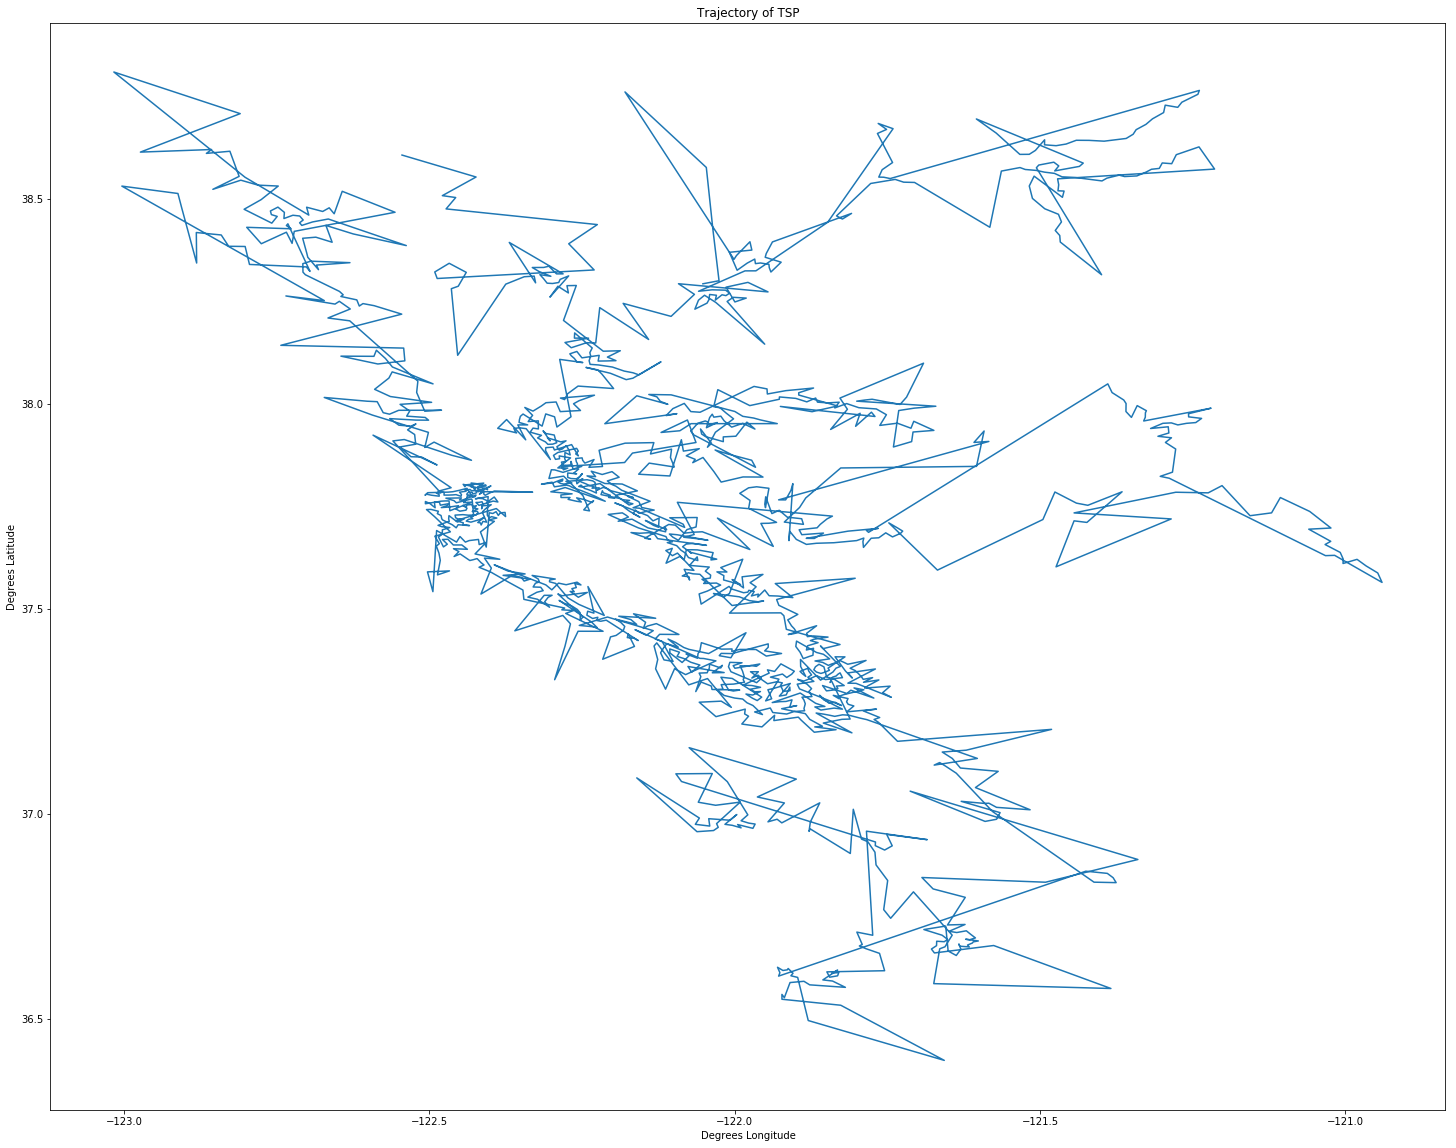

In [47]:
# QUESTION 10:
plt.figure(figsize=(25,20))

plt.plot(longitude, latitude)
plt.title('Trajectory of TSP')
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.show()

In [16]:
# QUESTION 11: Plot the road mesh 

# Load the cleaned graph data in
uber_gcc = np.loadtxt(directory + '/uber_gcc.txt')
uber_gcc_graph = {}
for row in uber_gcc:
    location_index = tuple(np.sort(row[0:2]).astype('int'))
    uber_gcc_graph[location_index] = row[2]

In [17]:
uber_gcc_ids = np.concatenate([uber_gcc[:,0],uber_gcc[:,1]])
uber_gcc_ids = np.unique(uber_gcc_ids).astype('int')

mean_coords = np.zeros((len(uber_gcc_ids),2))
for n,location_key in enumerate(uber_gcc_ids):
    mean_coords[n,:] = location_dictionary[str(location_key)]['mean_coord']

In [18]:
tri = Delaunay(mean_coords)

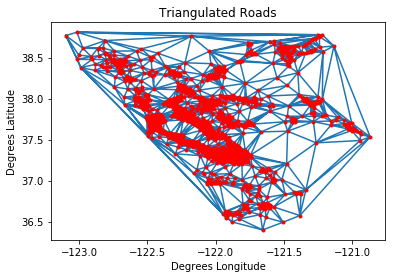

In [19]:
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads')
plt.show()

In [20]:
# Question 13:

# Generate a new graph file that can be used in igraph to compute max flow

MILES_PER_DEGREE_LATLON = 69

def get_time(loc1,loc2,transit_time_graph):
    if (loc1,loc2) in transit_time_graph.keys():
        return transit_time_graph[(loc1,loc2)]
    else:
        return 0

# Calculate flow as #cars/hour
def get_flow(loc1, loc2, transit_time_graph,location_dict):
    coord1 = location_dict[str(loc1)]['mean_coord']
    coord2 = location_dict[str(loc2)]['mean_coord']
    distance_miles = MILES_PER_DEGREE_LATLON * np.sqrt(np.sum(np.square(coord2-coord1)))
    if (loc1,loc2) in transit_time_graph.keys():
        travel_time_hours = transit_time_graph[(loc1,loc2)] / 3600
        speed_mph = distance_miles / travel_time_hours
        flow = (2*speed_mph) / (0.003 + (speed_mph/1800))
        return flow
    else:
        return 0


def add_triangulated_edge(graph, triangle):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:]))   

    flow12 = get_flow(edge12[0],edge12[1],uber_gcc_graph,location_dictionary)
    flow13 = get_flow(edge13[0],edge13[1],uber_gcc_graph,location_dictionary)
    flow23 = get_flow(edge23[0],edge23[1],uber_gcc_graph,location_dictionary)
    if edge12 not in graph.keys() and flow12 > 0:
        graph[edge12] = flow12
    if edge13 not in graph.keys() and flow13 > 0:
        graph[edge13] = flow13
    if edge23 not in graph.keys() and flow23 > 0:
        graph[edge23] = flow23

def add_travel_time_edge(graph,triangle,thresh):
    edge12 = tuple(np.sort(triangle[:2]))
    edge13 = tuple(np.sort(triangle[0::2]))
    edge23 = tuple(np.sort(triangle[1:]))   
    
    time12 = get_time(edge12[0],edge12[1],uber_gcc_graph)
    time13 = get_time(edge13[0],edge13[1],uber_gcc_graph)
    time23 = get_time(edge23[0],edge23[1],uber_gcc_graph)
    
    if edge12 not in graph.keys() and time12 < thresh and time12 > 0:
        graph[edge12] = time12
    if edge13 not in graph.keys() and time13 < thresh and time13 > 0:
        graph[edge13] = time13
    if edge23 not in graph.keys() and time23 < thresh and time23 > 0:
        graph[edge23] = time23

In [21]:
triangulated_graph = {}

for triangle_idx in tri.simplices:
    triangle = [uber_gcc_ids[triangle_idx[0]], uber_gcc_ids[triangle_idx[1]], uber_gcc_ids[triangle_idx[2]]]
    add_triangulated_edge(triangulated_graph,triangle)

In [22]:
# Write out a txt file with triangulated data
# This will be used in R's igraph library to do graph analysis
with open(directory + '/triangulated_graph.txt','w') as f:
    for locations in triangulated_graph:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),triangulated_graph[locations])
        f.write(string)

In [23]:
# Locate the IDs for Stanford and UCSC
for i in location_dictionary.keys():
    if location_dictionary[i]['display_name'] == '100 Campus Drive, Stanford':
        print("Stanford ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))
    if location_dictionary[i]['display_name'] == '700 Meder Street, Santa Cruz':
        print("UCSC ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))
    # SF ID = 46
#     Oakland ID = 9
# Hayward = 108
# # Foster City = 974
#     if 'Foster City' in location_dictionary[i]['display_name']:
#         print(location_dictionary[i]['display_name']+ " ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))
#     if 'Hayward' in location_dictionary[i]['display_name']:
#         print(location_dictionary[i]['display_name']+ " ID = " + str(i) + ", " + str(location_dictionary[i]['mean_coord']))

UCSC ID = 1968, [-122.06456181   36.97416881]
Stanford ID = 2607, [-122.17598222   37.42968589]


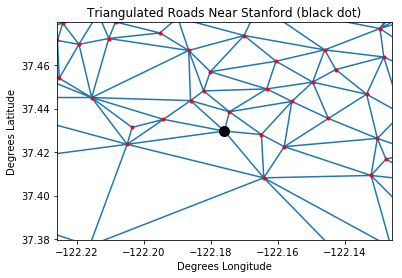

In [24]:
# Q13 
stanford_coords = location_dictionary['2607']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((stanford_coords[0]-0.05,stanford_coords[0]+0.05))
plt.ylim((stanford_coords[1]-0.05,stanford_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Near Stanford (black dot)')
plt.show()

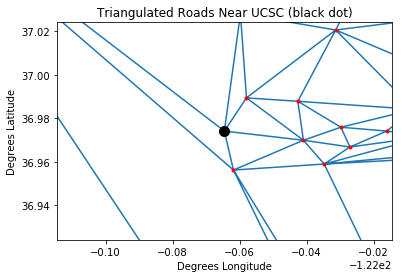

In [25]:
#Q13 Continued
ucsc_coords = location_dictionary['1968']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.05,ucsc_coords[0]+0.05))
plt.ylim((ucsc_coords[1]-0.05,ucsc_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Near UCSC (black dot)')
plt.show()

In [26]:
#Q14 Prune the graph
triangulated_time_graph = {}
THRESH = 60*12

for triangle_idx in tri.simplices:
    triangle = [uber_gcc_ids[triangle_idx[0]], uber_gcc_ids[triangle_idx[1]], uber_gcc_ids[triangle_idx[2]]]
    add_travel_time_edge(triangulated_time_graph, triangle, THRESH)
    
len(triangulated_time_graph)

5074

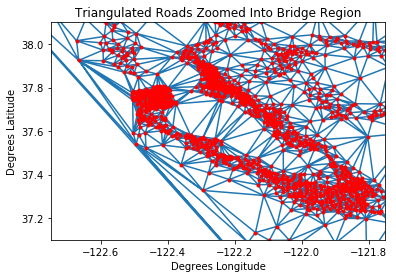

In [27]:
#Q14 Plot the original region near the bay
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(mean_coords[:,0], mean_coords[:,1],'r.')
plt.ylim((37.6-0.5,37.6+0.5))
plt.xlim((-122.25-0.5,-122.25+0.5))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Triangulated Roads Zoomed Into Bridge Region')
plt.show()

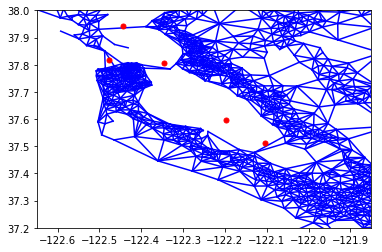

In [28]:
#Q15 Plot the pruned graph

plt.figure()
counter = 0
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.ylim((37.6-0.4,37.6+0.4))
plt.xlim((-122.25-0.4,-122.25+0.4))

bridge1 = [(-122.475+-122.479)/2, (37.806+37.83)/2]
bridge2 = [(-122.501+-122.387)/2, (37.956+37.93)/2]
bridge3 = [(-122.273+-122.122)/2, (37.563+37.627)/2]
bridge4 = [(-122.142+-122.067)/2, (37.486+37.54)/2]
bridge5 = [(-122.388+-122.302)/2, (37.788+37.825)/2]

bridges = np.array([bridge1,bridge2,bridge3,bridge4,bridge5])
plt.plot(bridges[:,0],bridges[:,1],'r.',ms=10)
plt.show()

In [29]:
#Q15 - Generate the pruned graph as a text file to be read into R
with open(directory + '/pruned_triangulated_graph.txt','w') as f:
    for loc_pairs in triangulated_time_graph.keys():
        flow = get_flow(loc_pairs[0],loc_pairs[1], uber_gcc_graph, location_dictionary)
        if flow > 0:
            string = '{} {} {:.2f}\n'.format(int(loc_pairs[0]),int(loc_pairs[1]),flow)
            f.write(string)

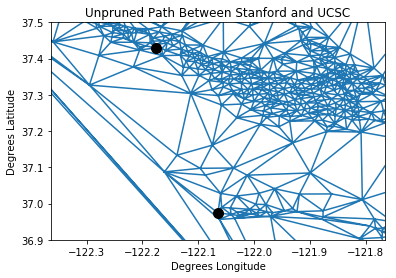

In [30]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
plt.triplot(mean_coords[:,0], mean_coords[:,1], tri.simplices.copy())
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.3,ucsc_coords[0]+0.3))
plt.ylim((37.2-0.3,37.2+0.3))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Unpruned Path Between Stanford and UCSC')
plt.show()

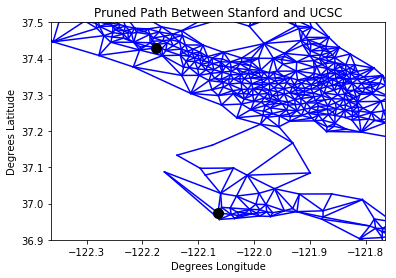

In [31]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.3,ucsc_coords[0]+0.3))
plt.ylim((37.2-0.3,37.2+0.3))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path Between Stanford and UCSC')
plt.show()

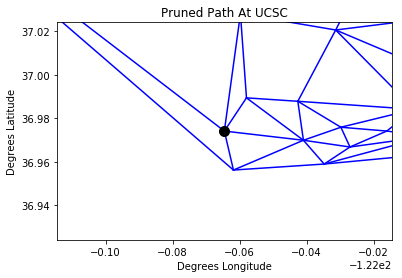

In [32]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(ucsc_coords[0],ucsc_coords[1],'k.',ms=20)
plt.xlim((ucsc_coords[0]-0.05,ucsc_coords[0]+0.05))
plt.ylim((ucsc_coords[1]-0.05,ucsc_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path At UCSC')
plt.show()

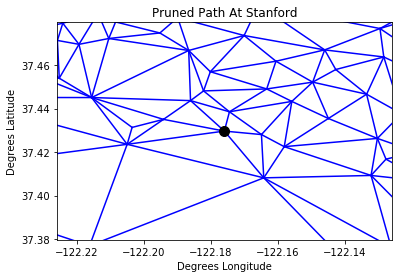

In [33]:
#Q15 Continued
stanford_coords = location_dictionary['2607']['mean_coord']
ucsc_coords = location_dictionary['1968']['mean_coord']
for edges in triangulated_time_graph.keys():
    coords1 = location_dictionary[str(edges[0])]['mean_coord']
    coords2 = location_dictionary[str(edges[1])]['mean_coord']
    plt.plot([coords1[0],coords2[0]],[coords1[1],coords2[1]],color='b')
plt.plot(stanford_coords[0],stanford_coords[1],'k.',ms=20)
plt.xlim((stanford_coords[0]-0.05,stanford_coords[0]+0.05))
plt.ylim((stanford_coords[1]-0.05,stanford_coords[1]+0.05))
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title('Pruned Path At Stanford')
plt.show()